In [99]:

import pandas as pd
from pandas import factorize
import numpy as np
import warnings

import re
import os
import json

import plotly.express as px

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, log_loss, roc_curve, auc, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

from sklearn.impute import KNNImputer

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(10,5)

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import shap
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV, train_test_split

import optuna
import optuna.visualization as vis
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings("ignore")

In [621]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('tested.csv')
entire_df = pd.concat([train_df, test_df], axis = 0)

Text(0.5, 1.0, 'Test Dataset: Missing Values')

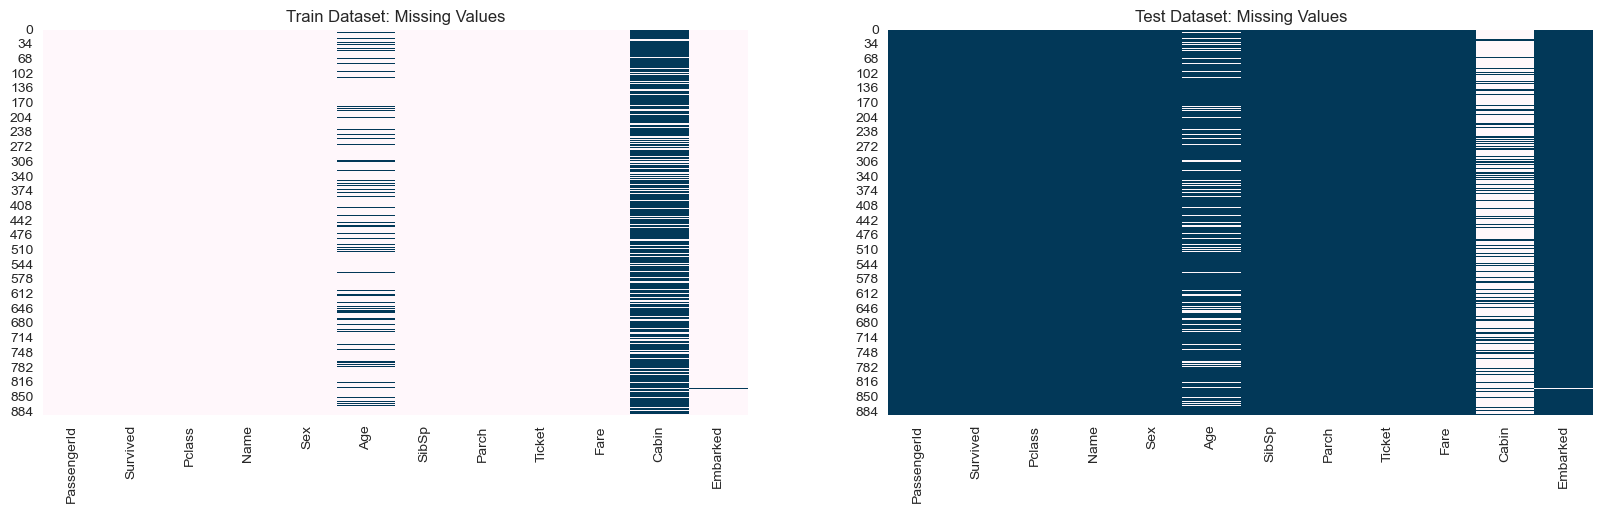

In [622]:
##lets check null value in both datasets
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.heatmap(train_df.isnull(), cbar=False, cmap='PuBu',ax=ax[0])
ax[0].set_title('Train Dataset: Missing Values')
sns.heatmap(train_df.isnull(), cbar=False, cmap='PuBu_r',ax=ax[1])
ax[1].set_title('Test Dataset: Missing Values')

In [623]:
# Show missing values for the entire dataset
def missing_tbl(df):
    tbl = pd.DataFrame()
    
    tbl['Column'] = df.columns
    tbl['Missing'] = [df[col].isnull().sum() for col in df.columns]
    tbl['Percentage'] = [round((df[col].isnull().sum() / df.shape[0])*100, 2) for col in df.columns]
    return tbl


missing_tbl(entire_df)

,Column,Missing,Percentage
0,PassengerId,0,0.00
1,Survived,0,0.00
2,Pclass,0,0.00
3,Name,0,0.00
4,Sex,0,0.00
5,Age,263,20.09
6,SibSp,0,0.00
7,Parch,0,0.00
8,Ticket,0,0.00
9,Fare,1,0.08


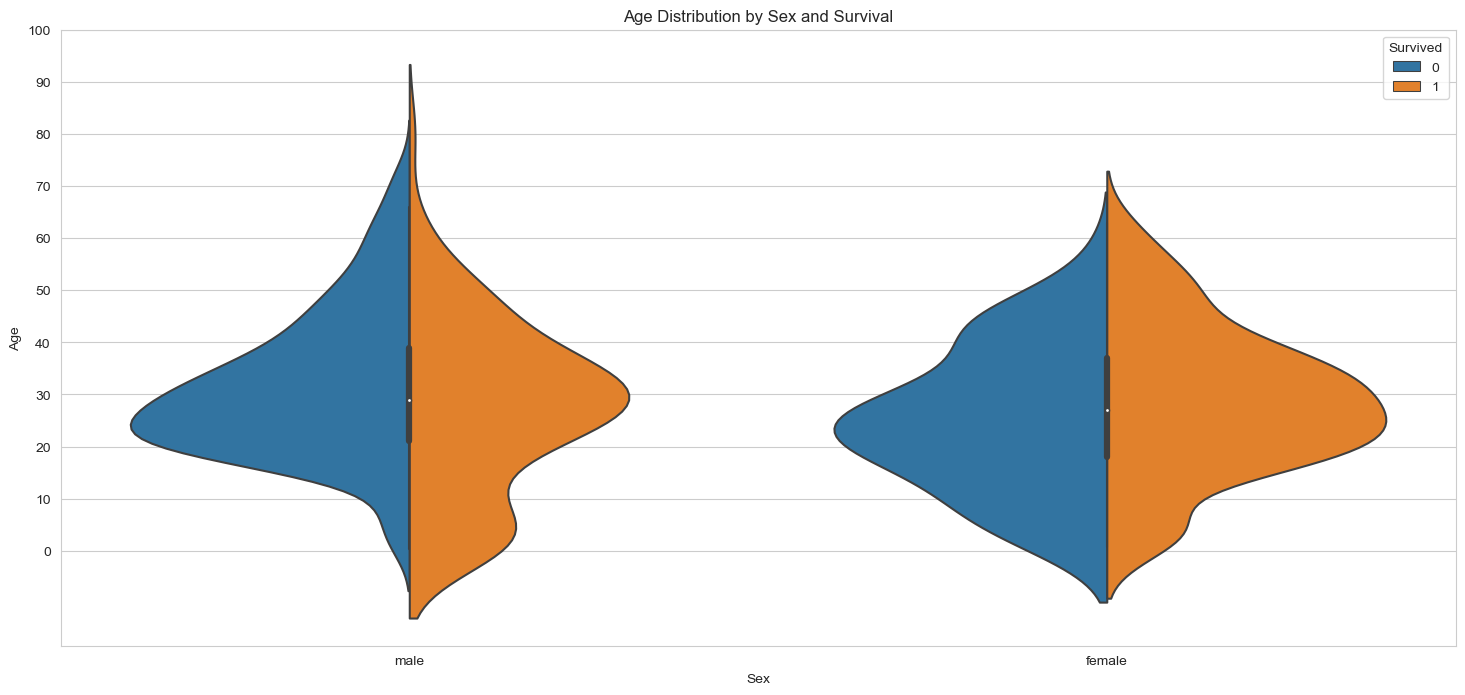

In [624]:
f, ax = plt.subplots(figsize=(18, 8))
sns.violinplot(x='Sex', y='Age', hue="Survived", data=train_df, split=True, ax=ax)
ax.set_yticks(range(0, 110, 10))
plt.title("Age Distribution by Sex and Survival")
plt.show()

In [625]:
age_by_pclass_sex = entire_df.groupby(['Sex', 'Pclass'])['Age'].median()

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {} '.format(pclass, sex, age_by_pclass_sex[sex][pclass].astype(int)))

# Filling the missing values in Age with the medians of Sex and Pclass groups
entire_df['Age'] = (
    entire_df.groupby(['Sex', 'Pclass'])['Age']
    .apply(lambda x: x.fillna(x.median()))
    .reset_index(drop=True) 
)

Median age of Pclass 1 females: 36 
Median age of Pclass 1 males: 42 
Median age of Pclass 2 females: 28 
Median age of Pclass 2 males: 29 
Median age of Pclass 3 females: 22 
Median age of Pclass 3 males: 25 


In [626]:
entire_df[entire_df['Embarked'].isnull()]

## here actually we can google for info

entire_df['Embarked'] = entire_df['Embarked'].fillna('S')

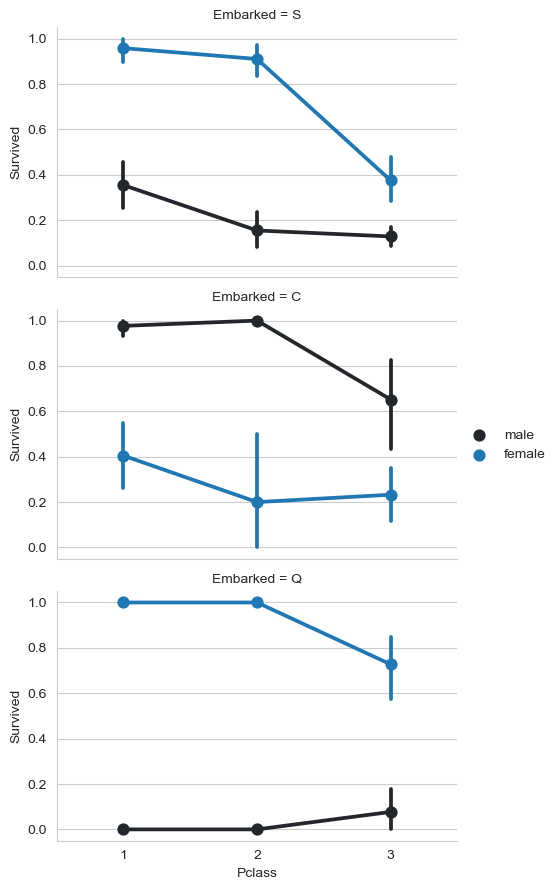

In [627]:
##check survival from embs 

FacetGrid = sns.FacetGrid(train_df, row='Embarked', aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex')
FacetGrid.add_legend()

In [ ]:
###appears to be connected to survival based on Pclass and sex.
# ##The chances of survival are better for women on ports Q and S. If they are at port C, the opposite is true.
# If a man is on port C, his chances of surviving are great; if he is on port Q or S, his chances are low.

In [628]:
##Fare
entire_df[entire_df['Fare'].isnull()]

# Median of a Fare satisying condition([3][0][0] -- 3=Pclass,0=Parch,SibSp) 
entire_df['Fare'] = entire_df['Fare'].fillna(
entire_df.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].median()[3][0][0])

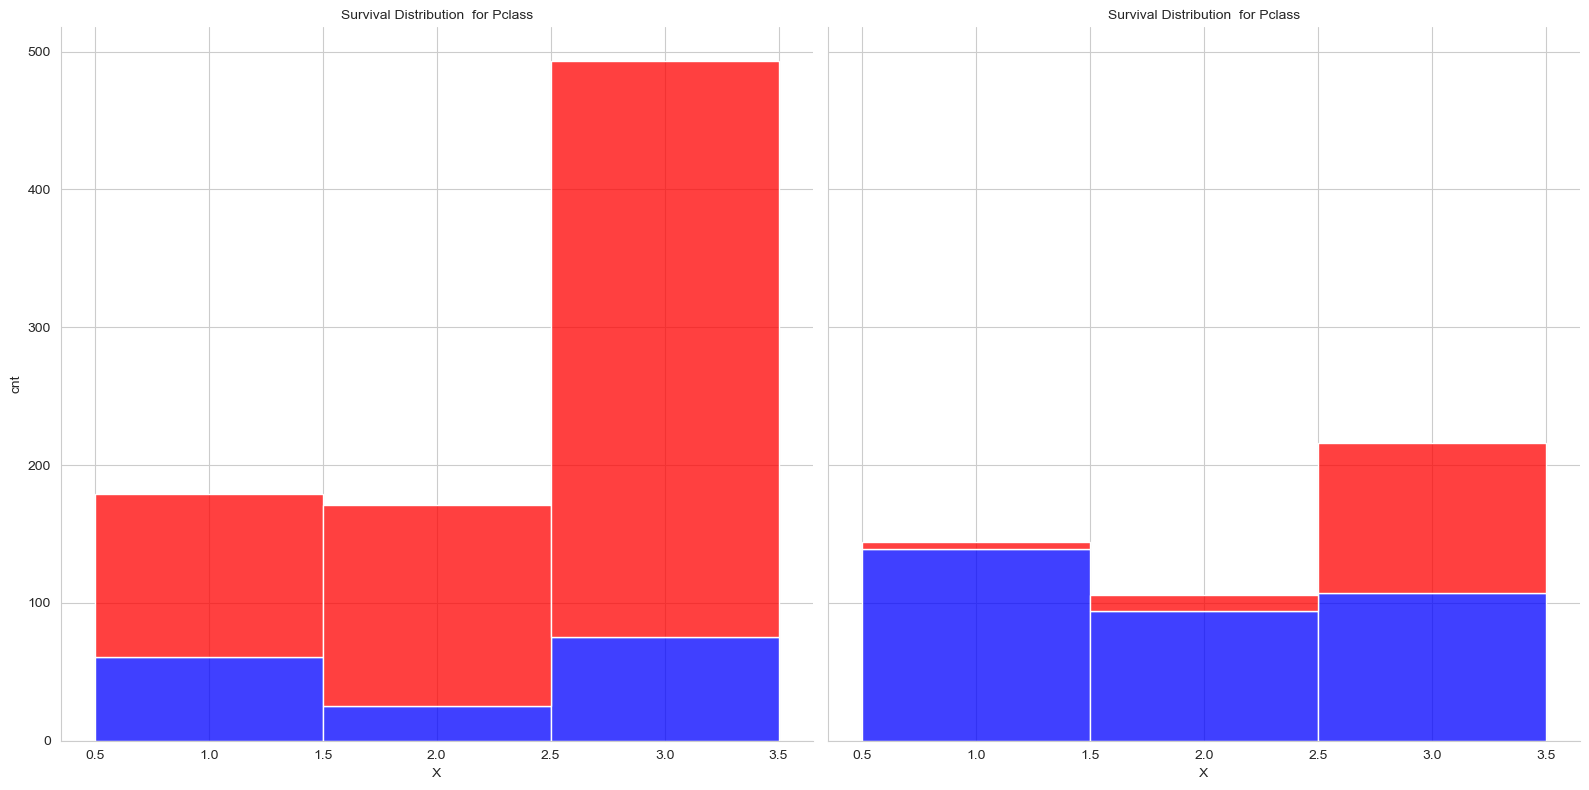

In [631]:

g = sns.FacetGrid(entire_df, col='Sex', height=8, aspect=1)


g.map_dataframe(sns.histplot, x='Pclass', bins=2, hue='Survived', multiple="stack", kde=False, discrete=True
                ,palette={0: 'red', 1: 'blue'})
g.set_axis_labels('X', 'cnt')
g.set_titles('Survival Distribution  for Pclass')
plt.show()

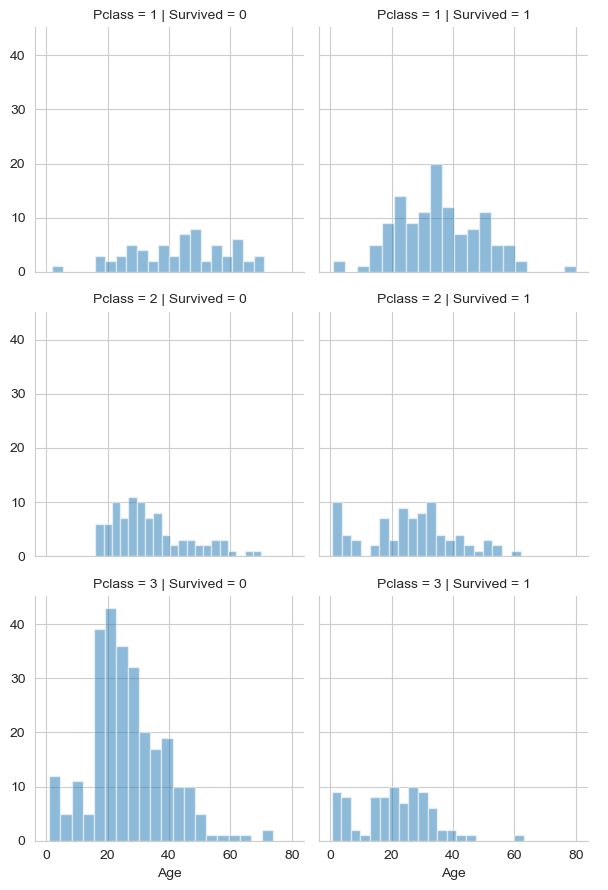

In [632]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', aspect=1)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [633]:
## add feature of family size
entire_df['Fam'] = entire_df['SibSp'] + entire_df['Parch'] + 1

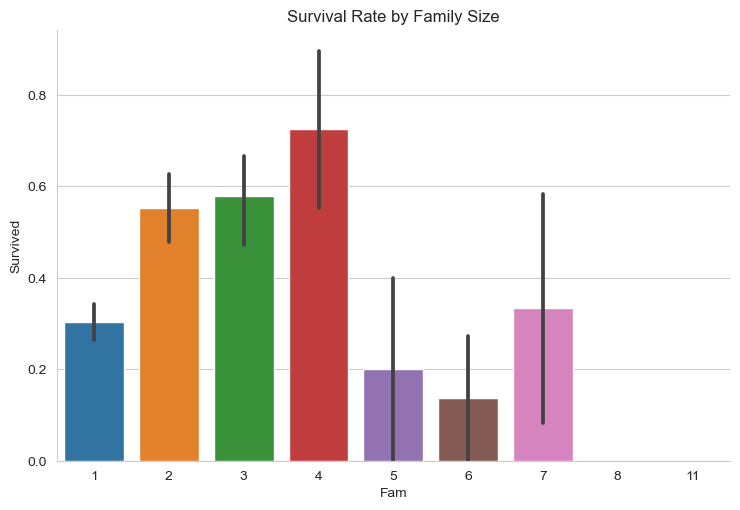

In [634]:
sns.catplot(x='Fam', y='Survived', data=entire_df.iloc[:891], kind='bar', aspect=1.5)

plt.title('Survival Rate by Family Size')
plt.show()

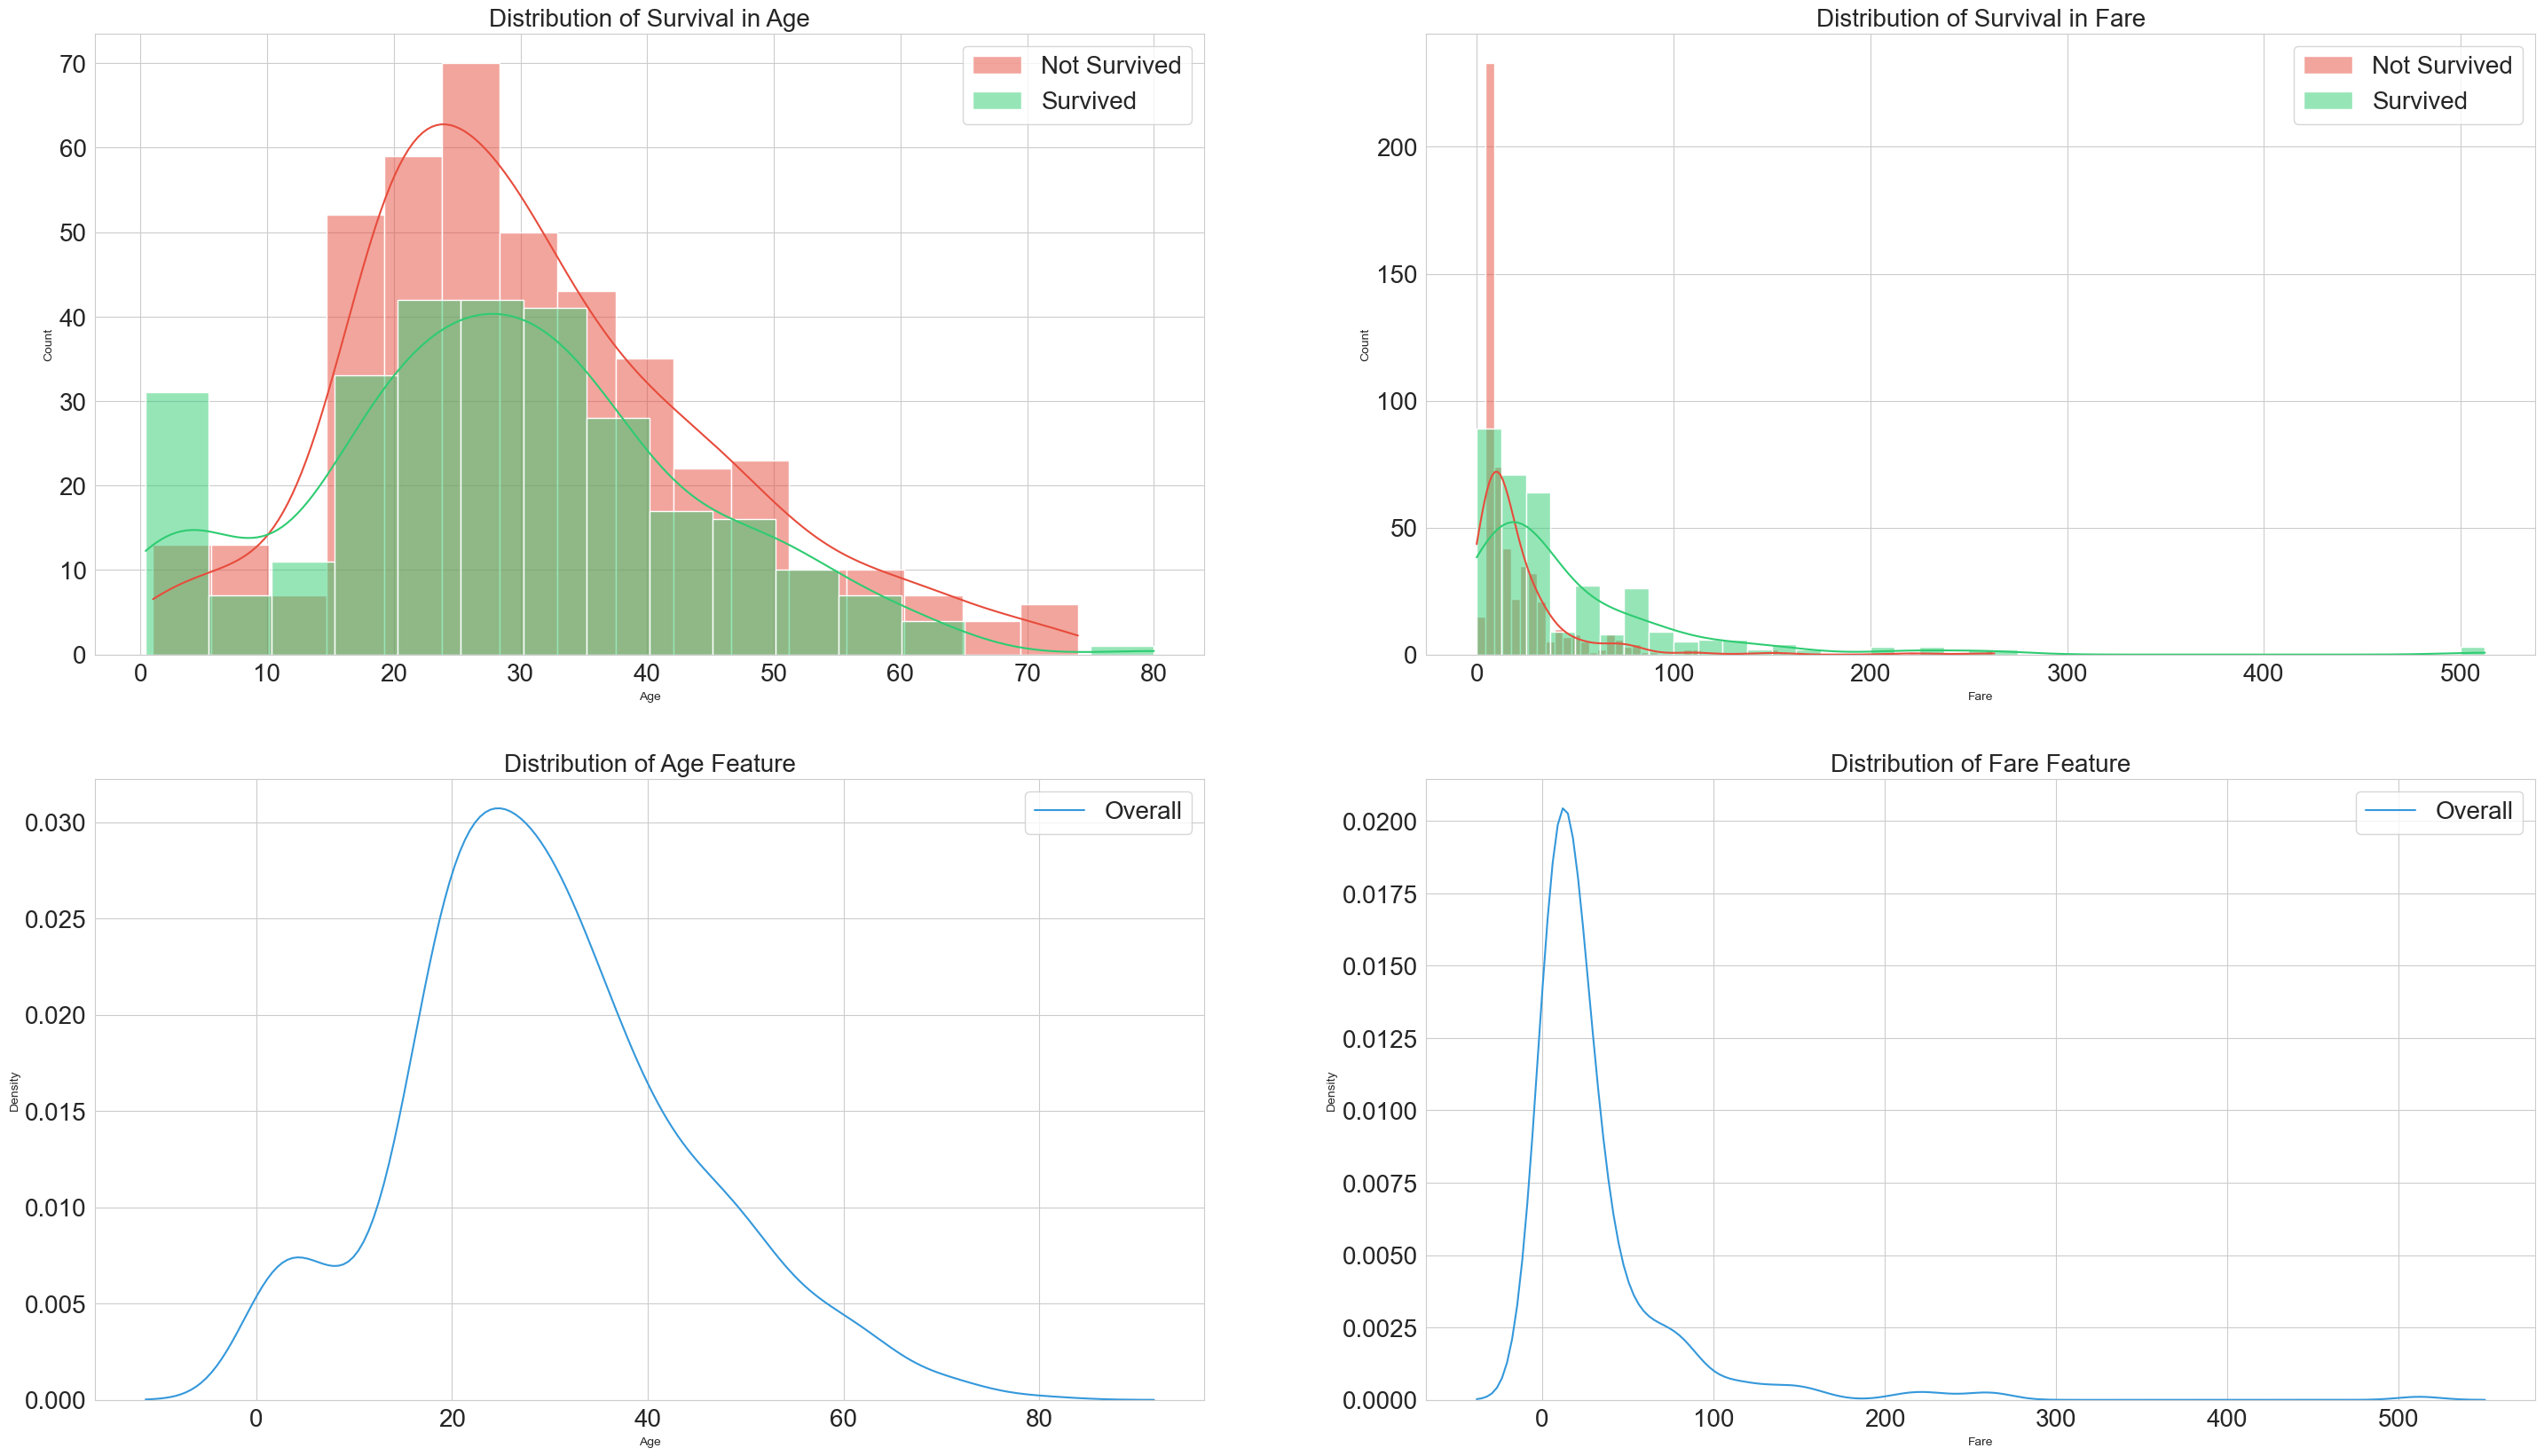

In [635]:
cont_features = ['Age', 'Fare']
surv = train_df['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):
    sns.histplot(train_df[~surv][feature], label='Not Survived', color='#e74c3c', kde=True, ax=axs[0][i])
    sns.histplot(train_df[surv][feature], label='Survived', color='#2ecc71', kde=True, ax=axs[0][i])
    sns.kdeplot(train_df[feature], label='Overall', color='#3498db', ax=axs[1][i])

    for j in range(2):
        axs[j][i].tick_params(axis='both', labelsize=20)
        axs[j][i].legend(loc='upper right', fontsize=20)
        
    axs[0][i].set_title(f'Distribution of Survival in {feature}', fontsize=20)
    axs[1][i].set_title(f'Distribution of {feature} Feature', fontsize=20)

plt.show()


In [636]:
# Create Title column by extracting title from Name column
def create_title(df):
    df = df.copy()
    df['Title'] = df['Name'].str.split(', ', expand=True)[1]
    df['Title'] = df['Title'].str.split('.', expand=True)[0]
    return df


entire_df = create_title(entire_df)

In [637]:
entire_df.drop(['Cabin'], axis=1, inplace=True)

In [638]:
entire_df['Fare'] = pd.qcut(entire_df['Fare'], 10) 

In [639]:
def age_to_category(age):
    if age < 6:
        return 'Infant'
    elif age < 16:
        return 'Child'
    elif age < 19:
        return 'Teenager'
    elif age < 40:
        return 'Adult'
    elif age < 51:
        return 'Adult_plus'
    else:
        return 'Senior'

entire_df['Age_Category'] = entire_df['Age'].apply(age_to_category)

age_categories = pd.get_dummies(entire_df['Age_Category'], prefix='Age').astype('int')
entire_df = pd.concat([entire_df, age_categories], axis=1)


In [641]:
entire_df['Is_Married'] = 0
entire_df['Is_Married'].loc[entire_df['Title'] == 'Mrs'] = 1

In [642]:
from string import punctuation

In [643]:
non_numeric_features = ['Fam', 'Fare']

for feature in non_numeric_features:        
    entire_df[feature] = LabelEncoder().fit_transform(entire_df[feature])

In [644]:
encoder_Sex = OneHotEncoder(sparse_output=False, drop='first')
sex_encoded = encoder_Sex.fit_transform(entire_df[['Sex']])
sex_encoded_df = pd.DataFrame(sex_encoded, columns=encoder_Sex.get_feature_names_out(['Sex'])).astype(int)

for col in sex_encoded_df.columns:
    entire_df[col] = sex_encoded_df[col]

In [645]:
entire_df.Title = entire_df.Title.replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 
                                        'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
entire_df.Title = entire_df.Title.replace('Mlle', 'Miss')
entire_df.Title = entire_df.Title.replace('Ms', 'Miss')
entire_df.Title = entire_df.Title.replace('Mme', 'Mrs')


encoder_title = OneHotEncoder(sparse_output=False, drop='first')
title_encoded = encoder_title.fit_transform(entire_df[['Title']])
title_encoded_df = pd.DataFrame(title_encoded, columns=encoder_title.get_feature_names_out(['Title'])).astype(int)
# add title columns
for col in title_encoded_df.columns:
    entire_df[col] = title_encoded_df[col]

In [646]:
encoder_embarked = OneHotEncoder(sparse_output=False, drop='first')
embarked_encoded = encoder_embarked.fit_transform(entire_df[['Embarked']])
embarked_encoded_df = pd.DataFrame(embarked_encoded, columns=encoder_embarked.get_feature_names_out(['Embarked'])).astype(int)

for col in embarked_encoded_df.columns:
    entire_df[col] = embarked_encoded_df[col]

In [650]:
entire_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Fam', 'Title', 'Age_Category',
       'Age_Adult', 'Age_Adult_plus', 'Age_Child', 'Age_Infant', 'Age_Senior',
       'Age_Teenager', 'Is_Married', 'Sex_male', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare', 'Title_the Countess', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [662]:
X_train = entire_df[entire_df.PassengerId <= 891][[ 'Pclass', 'Fare', 'Parch', 'Fam', 
       'Age_Adult',  'Age_Infant', 'Age_Senior',
        'Sex_male',  'Embarked_Q'
      ]]
y_train = entire_df[entire_df.PassengerId <= 891]['Survived']

X_valid = entire_df[entire_df.PassengerId > 891][[ 'Pclass', 'Fare', 'Parch', 'Fam', 
       'Age_Adult',  'Age_Infant', 'Age_Senior',
        'Sex_male',  'Embarked_Q'
      ]]
y_valid = entire_df[entire_df.PassengerId > 891]['Survived']

Random Forest:
  Accuracy (Train): 88.78%
  Accuracy (Test): 57.89%
  Log Loss (Train): 0.2709
  Log Loss (Test): 1.7770
--------------------------------------------------
SGD:
  Accuracy (Train): 76.99%
  Accuracy (Test): 62.20%
  Log Loss (Train): 0.7857
  Log Loss (Test): 1.3491
--------------------------------------------------
Linear SVC:
  Accuracy (Train): 79.46%
  Accuracy (Test): 53.59%
  Log Loss (Train): 4.7352
  Log Loss (Test): 8.8716
--------------------------------------------------
KNN:
  Accuracy (Train): 84.06%
  Accuracy (Test): 61.72%
  Log Loss (Train): 1.3019
  Log Loss (Test): 3.6194
--------------------------------------------------
Gaussian Naive Bayes:
  Accuracy (Train): 77.33%
  Accuracy (Test): 56.46%
  Log Loss (Train): 0.4955
  Log Loss (Test): 0.9365
--------------------------------------------------
SVC:
  Accuracy (Train): 80.70%
  Accuracy (Test): 54.07%
  Log Loss (Train): 0.4691
  Log Loss (Test): 0.8188
---------------------------------------------

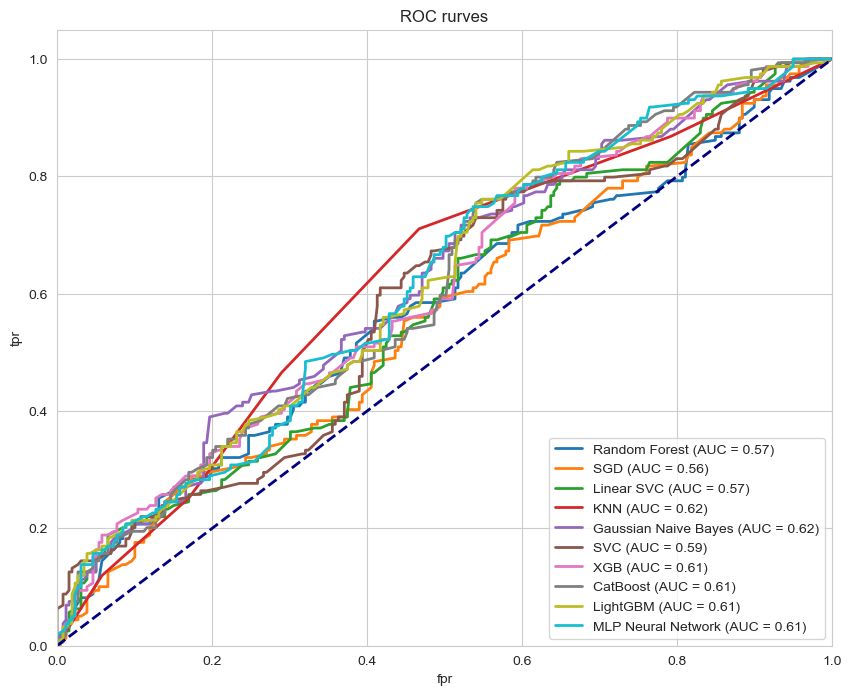

In [663]:

class ModelEvaluator:
    def __init__(self, X_train, Y_train, X_test, Y_test):
        self.X_train = X_train
        self.Y_train = y_train
        self.X_test = X_valid
        self.Y_test = y_valid
        self.models = [
            ("Random Forest", RandomForestClassifier()),
            ("SGD", SGDClassifier(loss='log')),
            ("Linear SVC", LinearSVC()),
                        ('KNN', KNeighborsClassifier()),
            ("Gaussian Naive Bayes", GaussianNB()),
            ("SVC", SVC(probability=True)),
            ("XGB", xgb.XGBClassifier()),
            ("CatBoost", CatBoostClassifier(loss_function='Logloss', verbose=0)),
            ("LightGBM", lgb.LGBMClassifier()),
            ("MLP Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42))
        ]

    def calculate_log_loss(self, model):
        if hasattr(model, "predict_proba"):
            probas_train = model.predict_proba(self.X_train)
            probas_test = model.predict_proba(self.X_test)
        else:
            probas_train = model.decision_function(self.X_train)
            probas_test = model.decision_function(self.X_test)

        log_loss_train = log_loss(self.Y_train, probas_train)
        log_loss_test = log_loss(self.Y_test, probas_test)
        return log_loss_train, log_loss_test


    def train_and_evaluate_models(self):
        for name, model in self.models:
            model.fit(self.X_train, self.Y_train)
            
            # Accuracy
            acc_train = accuracy_score(self.Y_train, model.predict(self.X_train)) * 100
            acc_test = accuracy_score(self.Y_test, model.predict(self.X_test)) * 100
            
            # Log Loss
            log_loss_train, log_loss_test = self.calculate_log_loss(model)
            
            # Print results
            print(f"{name}:")
            print(f"  Accuracy (Train): {acc_train:.2f}%")
            print(f"  Accuracy (Test): {acc_test:.2f}%")
            print(f"  Log Loss (Train): {log_loss_train:.4f}")
            print(f"  Log Loss (Test): {log_loss_test:.4f}")
            print("-" * 50)
        
    

    def plot_roc_curve(self):
        plt.figure(figsize=(10, 8))

        for name, model in self.models:
            if hasattr(model, "predict_proba"):
                probas_ = model.predict_proba(self.X_test)[:, 1]
            else:
                probas_ = model.decision_function(self.X_test)

            fpr, tpr, _ = roc_curve(self.Y_test, probas_)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

        # random roc to compare
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title('ROC rurves')
        plt.legend(loc="lower right")
        plt.show()


evaluator = ModelEvaluator(X_train, y_train, X_valid, y_valid)
evaluator.train_and_evaluate_models()
evaluator.plot_roc_curve()

In [436]:

models = [
 ("Random Forest", RandomForestClassifier()),
            ("SGD", SGDClassifier(loss='log')),
            ("Linear SVC", LinearSVC()),
            ('KNN', KNeighborsClassifier()),
            ("Gaussian Naive Bayes", GaussianNB()),
            ("SVC", SVC(probability=True)),
            ("XGB", xgb.XGBClassifier()),
            ("CatBoost", CatBoostClassifier(loss_function='Logloss', verbose=0)),
            ("LightGBM", lgb.LGBMClassifier()),
            ("MLP Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42))
        ]

def calculate_log_loss(model, X_train, y_train, X_valid, y_valid):
    if hasattr(model, "predict_proba"):
        probas_train = model.predict_proba(X_train)
        probas_test = model.predict_proba(X_valid)
    else:
        probas_train = model.decision_function(X_train)
        probas_test = model.decision_function(X_valid)

    log_loss_train = log_loss(y_train, probas_train)
    log_loss_test = log_loss(y_valid, probas_test)
    return log_loss_train, log_loss_test

# Initialize lists to store the metrics
precision_train_list = []
precision_test_list = []
recall_train_list = []
recall_test_list = []
f1_train_list = []
f1_test_list = []
roc_auc_train_list = []
roc_auc_test_list = []
model_names = []
acc_train_list = []
acc_test_list = []
log_loss_train_list = []
log_loss_test_list = []

# Iterate through models and compute metrics
for name, model in models:
    try:
        model.fit(X_train, y_train)
        
        # Accuracy
        acc_train = accuracy_score(y_train, model.predict(X_train)) * 100
        acc_test = accuracy_score(y_valid, model.predict(X_valid)) * 100
        
        # Log Loss
        log_loss_train, log_loss_test = calculate_log_loss(model, X_train, y_train, X_valid, y_valid)
        
        # Precision
        precision_train = precision_score(y_train, model.predict(X_train))
        precision_test = precision_score(y_valid, model.predict(X_valid))
        
        # Recall
        recall_train = recall_score(y_train, model.predict(X_train))
        recall_test = recall_score(y_valid, model.predict(X_valid))
        
        # F1-Score
        f1_train = f1_score(y_train, model.predict(X_train))
        f1_test = f1_score(y_valid, model.predict(X_valid))
        
        # ROC AUC
        if hasattr(model, "predict_proba"):
            roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
            roc_auc_test = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
        else:
            roc_auc_train = roc_auc_score(y_train, model.decision_function(X_train))
            roc_auc_test = roc_auc_score(y_valid, model.decision_function(X_valid))
        
        # Append the model name and metrics to the lists
        model_names.append(name)
        precision_train_list.append(precision_train)
        precision_test_list.append(precision_test)
        recall_train_list.append(recall_train)
        recall_test_list.append(recall_test)
        f1_train_list.append(f1_train)
        f1_test_list.append(f1_test)
        roc_auc_train_list.append(roc_auc_train)
        roc_auc_test_list.append(roc_auc_test)
        
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        log_loss_train_list.append(log_loss_train)
        log_loss_test_list.append(log_loss_test)
        
    except Exception as e:
        # In case of any error, append np.nan or a default value
        print(f"Error with model {name}: {e}")
        model_names.append(name)
        precision_train_list.append(np.nan)
        precision_test_list.append(np.nan)
        recall_train_list.append(np.nan)
        recall_test_list.append(np.nan)
        f1_train_list.append(np.nan)
        f1_test_list.append(np.nan)
        roc_auc_train_list.append(np.nan)
        roc_auc_test_list.append(np.nan)
        
        acc_train_list.append(np.nan)
        acc_test_list.append(np.nan)
        log_loss_train_list.append(np.nan)
        log_loss_test_list.append(np.nan)

# Create DataFrame for model comparison
models_comparison = pd.DataFrame({
    'Model': model_names,
    'Score_train': acc_train_list,
    'Score_test': acc_test_list,
    'LogLoss_train': log_loss_train_list,
    'LogLoss_test': log_loss_test_list,
    'Precision_train': precision_train_list,
    'Precision_test': precision_test_list,
    'Recall_train': recall_train_list,
    'Recall_test': recall_test_list,
    'F1_train': f1_train_list,
    'F1_test': f1_test_list,
    'ROC_AUC_train': roc_auc_train_list,
    'ROC_AUC_test': roc_auc_test_list
})

# Sort the models by test accuracy
models_comparison = models_comparison.sort_values(by='Score_test', ascending=False)
models_comparison






,Model,Score_train,Score_test,LogLoss_train,LogLoss_test,Precision_train,Precision_test,Recall_train,Recall_test,F1_train,F1_test,ROC_AUC_train,ROC_AUC_test
9,MLP Neural Network,83.164983,78.468900,0.407152,0.499055,0.822148,0.731544,0.716374,0.685535,0.765625,0.707792,0.876059,0.805857
3,KNN,86.868687,78.229665,0.265943,2.560824,0.861736,0.712500,0.783626,0.716981,0.820827,0.714734,0.945376,0.814174
2,Linear SVC,81.818182,77.751196,4.252307,4.877782,0.792208,0.722973,0.713450,0.672956,0.750769,0.697068,0.867260,0.803963
5,SVC,84.062851,77.751196,0.399092,0.501497,0.826797,0.708861,0.739766,0.704403,0.780864,0.706625,0.894700,0.814623
1,SGD,81.818182,77.272727,0.450450,0.561000,0.763158,0.683908,0.763158,0.748428,0.763158,0.714715,0.865225,0.803332
0,Random Forest,100.000000,76.794258,0.093295,0.695677,1.000000,0.689024,1.000000,0.710692,1.000000,0.699690,1.000000,0.818411
7,CatBoost,93.602694,76.794258,0.229616,0.507071,0.961165,0.696203,0.868421,0.691824,0.912442,0.694006,0.974507,0.818897
8,LightGBM,99.326599,75.598086,0.078276,0.643751,0.991228,0.674847,0.991228,0.691824,0.991228,0.683230,0.999792,0.818800
6,XGB,100.000000,75.119617,0.055547,0.680571,1.000000,0.670807,1.000000,0.679245,1.000000,0.675000,1.000000,0.813822
4,Gaussian Naive Bayes,78.338945,74.401914,0.779206,1.038286,0.717201,0.652941,0.719298,0.698113,0.718248,0.674772,0.848113,0.786503


<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 9.8 KB
0.7822966507177034
0.7125
0.7169811320754716
0.7147335423197492
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       259
           1       0.71      0.72      0.71       159

    accuracy                           0.78       418
   macro avg       0.77      0.77      0.77       418
weighted avg       0.78      0.78      0.78       418

Confusion Matrix of Orginal model:


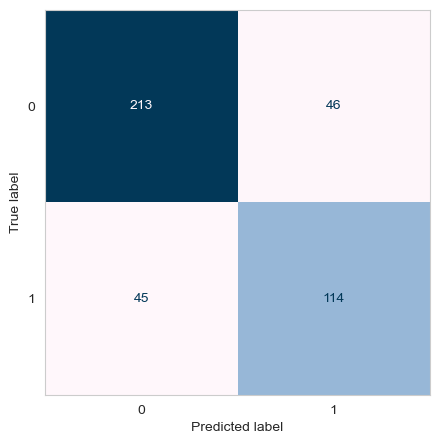

In [417]:
m = models[5][1]

test_df = entire_df.iloc[891:]
test_df = test_df[['Pclass',  'Sex',  'Fare', 'Title', 'Fam', 'Embarked', 'Ticket']]
test_y = entire_df.iloc[891:, 1]


prediction = m.predict(test_df)

submission = pd.DataFrame(entire_df.iloc[891:]['PassengerId'], columns=['PassengerId'])
submission['Survived'] = prediction

submission.info()
test_y = entire_df.iloc[891:, 1]

# Accuracy
print(accuracy_score(test_y, prediction))
# Precision
print(precision_score(test_y, prediction))
# Recall
print(recall_score(test_y, prediction))
# F1-Score
print(f1_score(test_y, prediction))


print(classification_report(test_y ,m.predict(test_df)))
print('Confusion Matrix of Orginal model:')
ConfusionMatrixDisplay.from_predictions(test_y, m.predict(test_df), colorbar = False, cmap = 'PuBu')
plt.grid(False)


In [275]:
submission.to_csv('sub_linear_svc.csv', index= False)

In [153]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

Best hyperparameters: {'C': 0.8445053184654049, 'gamma': 0.7370867297652205}
Best score: 0.7626387537746773
Accuracy: 0.784688995215311
Precision: 0.7225806451612903
Recall: 0.7044025157232704
F1-Score: 0.713375796178344
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       259
           1       0.72      0.70      0.71       159

    accuracy                           0.78       418
   macro avg       0.77      0.77      0.77       418
weighted avg       0.78      0.78      0.78       418

Confusion Matrix of Orginal model:


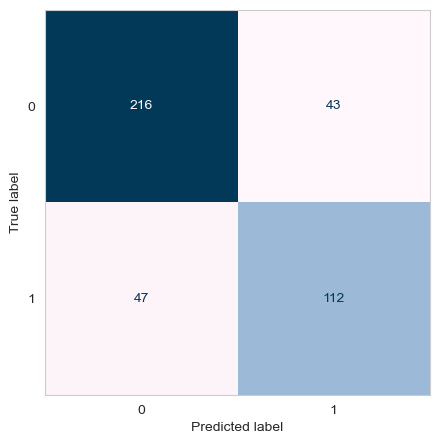

In [407]:
X_train = entire_df.iloc[0:891][['Pclass',  'Sex',  'Fare', 'Title', 'Fam', 'Embarked', 'Ticket']]
y_train = entire_df.iloc[0:891]['Survived']

from sklearn.model_selection import cross_val_score

def optuna_optimize(trial):
    param = {
        'C': trial.suggest_float('C', 1e-5, 0.9, log=True),
          'gamma': trial.suggest_float('gamma', 1e-5, 0.9, log=True)
    }
    model = SVC(**param)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(optuna_optimize, n_trials=1000)

print('Best hyperparameters:', study.best_params)
print('Best score:', study.best_value)


best_params = study.best_params
final_model = SVC(**best_params)


final_model.fit(X_train, y_train)
predictions = final_model.predict(test_df[['Pclass',  'Sex',  'Fare', 'Title', 'Fam', 'Embarked', 'Ticket']])


print("Accuracy:", accuracy_score(test_y, predictions))
print("Precision:", precision_score(test_y, predictions))
print("Recall:", recall_score(test_y, predictions))
print("F1-Score:", f1_score(test_y, predictions))


optuna.visualization.plot_param_importances(study)

print(classification_report(test_y ,predictions))
print('Confusion Matrix of Orginal model:')
ConfusionMatrixDisplay.from_predictions(test_y,predictions, colorbar = False, cmap = 'PuBu')
plt.grid(False)

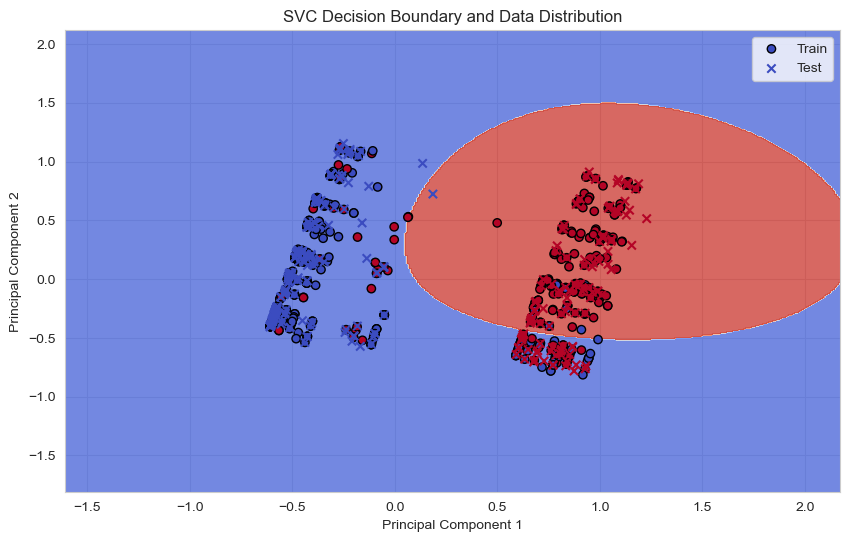

In [358]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(test_df[['Pclass', 'Sex', 'Fare', 'Title', 'Fam', 'Embarked', 'Ticket']])


final_model = SVC(probability=True, gamma= 0.495, C = 0.495)
final_model.fit(X_train_pca, y_train)
predictions = final_model.predict(X_test_pca)


x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = final_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')


plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap='coolwarm', label='Train')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_y, edgecolors='k', cmap='coolwarm', marker='x', label='Test')

plt.title("SVC Decision Boundary and Data Distribution")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

Best hyperparameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 4.599841876914718e-05, 'learning_rate': 'constant', 'max_iter': 400}
Best score: 0.8305504990270542
Accuracy: 0.7799043062200957
Precision: 0.710691823899371
Recall: 0.710691823899371
F1-Score: 0.710691823899371
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       259
           1       0.71      0.71      0.71       159

    accuracy                           0.78       418
   macro avg       0.77      0.77      0.77       418
weighted avg       0.78      0.78      0.78       418

Confusion Matrix of Original model:


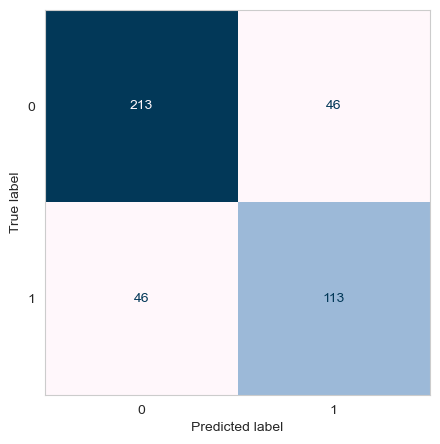

In [437]:
def optuna_optimize(trial):
    param = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 100)]),
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        'max_iter': trial.suggest_int('max_iter', 100, 500, step=50),
    }

    model = MLPClassifier(**param, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(optuna_optimize, n_trials=500)


print('Best hyperparameters:', study.best_params)
print('Best score:', study.best_value)


best_params = study.best_params
final_model = MLPClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)


predictions = final_model.predict(X_valid)


print("Accuracy:", accuracy_score(y_valid, predictions))
print("Precision:", precision_score(y_valid, predictions))
print("Recall:", recall_score(y_valid, predictions))
print("F1-Score:", f1_score(y_valid, predictions))


optuna.visualization.plot_param_importances(study)


print(classification_report(y_valid, predictions))
print('Confusion Matrix of Original model:')
ConfusionMatrixDisplay.from_predictions(y_valid, predictions, colorbar=False, cmap='PuBu')
plt.grid(False)
plt.show()

Accuracy: 0.7727272727272727
Precision: 0.7025316455696202
Recall: 0.6981132075471698
F1-Score: 0.7003154574132492
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       259
           1       0.70      0.70      0.70       159

    accuracy                           0.77       418
   macro avg       0.76      0.76      0.76       418
weighted avg       0.77      0.77      0.77       418

Confusion Matrix of Orginal model:


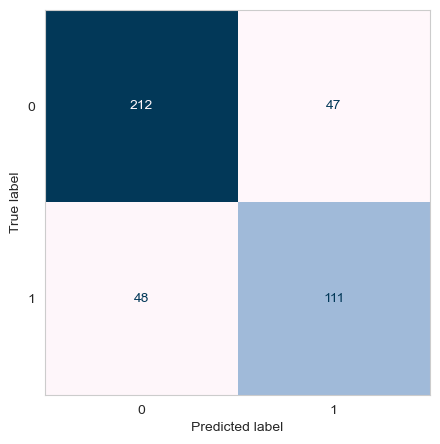

In [422]:
test_set = entire_df[entire_df.PassengerId >= 892][['Pclass',  'Sex',  'Fare', 'Title', 'Fam', 'Embarked', 'Ticket']]
target = entire_df[entire_df.PassengerId >= 892]['Survived']


final_model.fit(X_train, y_train)
predictions = final_model.predict(test_set)

print("Accuracy:", accuracy_score(target, predictions))
print("Precision:", precision_score(target, predictions))
print("Recall:", recall_score(target, predictions))
print("F1-Score:", f1_score(target, predictions))


optuna.visualization.plot_param_importances(study)

print(classification_report(target ,predictions))
print('Confusion Matrix of Orginal model:')
ConfusionMatrixDisplay.from_predictions(target,predictions, colorbar = False, cmap = 'PuBu')
plt.grid(False)

In [359]:
submission = pd.DataFrame(entire_df.iloc[891:]['PassengerId'], columns=['PassengerId'])
submission['Survived'] = predictions

submission.to_csv('sub_svc_optimized_gamma.csv', index= False)